In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
train_raw = pd.read_csv('/kaggle/input/bytedatahack-22/train.csv')

In [6]:
train_raw = train_raw[train_raw['target'] != -1]

In [13]:
class FullDescriptionCreator(BaseEstimator, TransformerMixin):
    """Добавляет столбец с полным описанием вакансии"""

    patt = re.compile("[^\s\w]")

    def __init__(self, responsibilities):
        self.responsibilities = responsibilities

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
#         X["responsibilities"] = self.responsibilities
        X["full_description"] = (
            X["name"] + " " + X["description"].fillna("")
        ).map(str.lower)
        X.loc[:, "full_description"] = X["full_description"].str.replace(
            self.patt, " ", regex=True
        )
        return X
    
class ClearHTML(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        CLEANR = re.compile('<.*?>') 
        
        X = X.copy()
        X['description'] = X['description'].astype(str)
        X['description'] = X['description'].apply(lambda raw_html: re.sub(CLEANR, '', raw_html))
        return X

class FillEmpty(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[X['description'].isnull(), 'description'] = X[X['description'].isnull()]['name']
        X['description'] = X['description'].str.replace('\n', ' ')
        return X

In [18]:
import json

with open(
    "/kaggle/input/bytedatahack-22/vacancy_descriptions/2_parsed.json", "r", encoding="utf8"
) as fp:
    descriptions = json.load(fp)

responsibilities = pd.Series(
    {
        description["ID"]: description["Content"].get("Обязанности")[0]
        if (description["Content"].get("Обязанности")) is not None
        else None
        for description in descriptions
    },
    name="responsibilities",
)

In [19]:
pipeline = make_pipeline(ClearHTML(), FillEmpty(), FullDescriptionCreator(responsibilities=responsibilities))

In [7]:
okz = pd.read_csv('/kaggle/input/bytedatahack-22/okz_3_4_professions.csv', sep='	')
n_classes = len(okz['code'].unique())

le = LabelEncoder()
le.fit(okz['code'].values)

LabelEncoder()

In [9]:
class ProcessedDataset():
  
    def __init__(self, df, mood='train'):
        proccesed_df = pipeline.fit_transform(df)
        
        if mood != 'eval':
            y = le.transform(df['target'].values)
            self.y = y
        self.x = proccesed_df['full_description'].values
        self.n_samples = len(proccesed_df)
        self.mood = mood 
    # support indexing such that dataset[i] can 
    # be used to get i-th sample
#     def tokenize(self, tokenize_func):
#         self.x = tokenize_func(list(self.x))
    def __getitem__(self, index):
        if self.mood == 'eval':
            return self.x[index]
        return self.x[index], self.y[index]
        
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
  

In [10]:
X_train, X_test = train_test_split(train_raw, test_size=.3)

In [11]:
train_dataset = ProcessedDataset(X_train)
test_dataset = ProcessedDataset(X_test)

NameError: name 'le' is not defined

In [11]:
tokenizer = AutoTokenizer.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")
model = AutoModelForSequenceClassification.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")

Downloading:   0%|          | 0.00/792 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [12]:
model.classifier.out_proj
for p in model.parameters():
    p.requires_grad = False
    
model.classifier.out_proj = nn.Linear(1024, n_classes)

optim = torch.optim.AdamW(model.classifier.out_proj.parameters(), lr=5e-5)

In [13]:
model.to(device); device

'cpu'

In [14]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

criterion = nn.CrossEntropyLoss()


In [15]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optim, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [16]:
lossi = []
cum_loss=0
n_batches = 0

In [18]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        
        batch = {k: v.to(device) for (k, v) in tokenizer(list(x_batch), truncation=True, padding=True, max_length=513, return_tensors='pt').items()}
#         batch = {k: v.to(device) for (k, v) in batch}
        outputs = model(**batch)
        loss = criterion(outputs.logits, y_batch.to(device))
        loss.backward()

        optim.step()
        lr_scheduler.step()
        optim.zero_grad()
        progress_bar.update(1)
        
        cum_loss += loss
        n_batches += 1
    lossi.append(cum_loss/n_batches)

  0%|          | 0/4110 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
emb_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
emb_model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model=emb_model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def iter_batches(x, y=None, shuffle=True, batch_size=256, device=device):
    indices = np.arange(len(x))
    
    if shuffle:
        indices = np.random.permutation(indices)
    
    for start in range(0, len(indices), batch_size):
        res = x.iloc[indices[start:start+batch_size]]['full_description'].apply(lambda x: list(embed_bert_cls(x)))
        res = torch.tensor(list(res.values), device=device)
#         emb = embed_bert_cls(list(x.iloc[indices[start:start+batch_size]]['full_description'].values), model, tokenizer)
        if type(y) == type(None):
            yield res 
        else:
            yield res, torch.tensor(y[indices[start:start+batch_size]], device=device)

In [12]:
next(iter_batches(X_train, y_train))[1]

tensor([150, 187, 467, 306, 313, 211, 182, 555, 359, 517, 409, 409, 285, 553,
        339, 128, 545, 304, 285, 133, 519, 541, 187, 414, 131, 386, 545, 409,
        131, 553, 403, 414, 467, 359, 339, 182, 546, 386, 386, 462, 133, 548,
        431, 523, 555, 370, 339, 546, 409, 266, 304, 414, 409, 545, 339, 211,
        128, 386, 386, 339, 443, 554, 545, 553, 554, 555, 443, 132, 313, 421,
        347, 347, 285, 339, 222, 467, 518, 477, 548, 409, 553, 386, 546, 386,
        554, 311, 545, 431, 369, 182, 409, 211, 211, 409, 285, 409, 386, 285,
        150, 409, 370, 520, 313, 182, 369, 359, 386, 347, 211, 386, 409, 306,
        306, 409, 339, 409, 523, 522, 409, 433, 401, 341, 313, 409, 361, 182,
        187, 386, 128, 409, 443, 128, 131, 403, 304, 386, 359, 285, 386, 293,
        386, 196, 359, 369, 445, 437, 554, 414, 545, 519, 133, 416, 462, 518,
        409, 359, 462, 548, 541, 211, 386, 409, 433, 339, 443, 545, 369, 133,
        520, 182, 290, 554, 211, 369, 403, 304, 401, 401, 414, 4

In [13]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes=n_classes, n_emb=312, n_hidden=100):
        super().__init__()
        self.fc1 = nn.Linear(n_emb, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
model = SimpleModel().to(device)

optim = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()



In [20]:
lossi = []

In [21]:
def train(model, optim, criterion, X=X_train, y=y_train, epochs=5, lossi=lossi):
    cum_loss = 0
    n_batches = 0
    
    model.train()
    for _ in range(epochs):
        for x_batch, y_batch in tqdm(iter_batches(X_train, y_train)):
            logits = model(x_batch)

            optim.zero_grad()
            loss = criterion(logits, y_batch)
            loss.backward()

            optim.step()

            lossi.append(loss)
            cum_loss += loss
            n_batches += 1

        lossi.append(cum_loss / n_batches)
        cum_loss = 0
        n_batches = 0

In [24]:
def compute_metrics(preds, targets):
    preds = preds.argmax(-1)
    f1 = f1_score(targets, preds, average='macro')
    accuracy = accuracy_score(targets, preds)
    return {'F1': f1, 'accuracy_score': accuracy}

In [55]:
logits = []
preds = None
targets = None
eval_model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(iter_batches(X_test, y_test, shuffle=False)):
        logits = eval_model(x_batch)
        if type(preds) == type(None):
            preds = F.softmax(logits)
            targets = y_batch
        else:
            preds = torch.cat([preds, F.softmax(logits)])
            targets = torch.cat([targets, y_batch])
        

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == "":


In [56]:
predictions = preds.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()

compute_metrics(predictions, targets)

{'F1': 0.33994065135024193, 'accuracy_score': 0.6851970181043664}

In [32]:
torch.save(eval_model.state_dict(), 'mlp_1_without_okz')

In [33]:
okz_train = pd.DataFrame(dict(name=okz['profession'], description=okz['description'], target=okz['code']));okz_train.head()

,name,description,target
0,Руководители (представители) федеральных и рег...,Руководители\n(представители) федеральных и р...,111
1,Руководители федеральных и региональных органо...,Руководители (представители) федеральных и ре...,1111
2,Руководители (представители) федеральных и рег...,\nРуководители (представители) федеральных и ...,1112
3,Руководители органов местного самоуправления,Руководители органов местного самоуправления ...,1113
4,Высшие должностные лица политических и обществ...,Высшие должностные лица политических\nи общес...,1114


In [34]:
okz_data = pipeline.transform(okz_train)

In [35]:
okz_train = okz_data.drop('target', axis=1)
okz_train_y = le.transform(okz_data['target'].values)

In [43]:
lossi = []

In [44]:
train(eval_model, optim, criterion, X=okz_train, y=okz_train_y, lossi=lossi)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

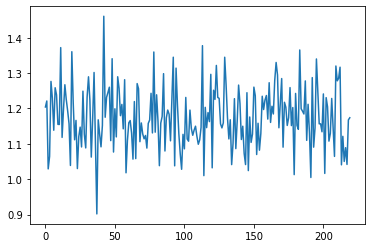

In [45]:
plt.plot(range(len(lossi)), [i.item() for i in lossi])

In [50]:
lossi = []

In [52]:
train(eval_model, optim, criterion, X=X_test, y=y_test, lossi=lossi, epochs=10)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

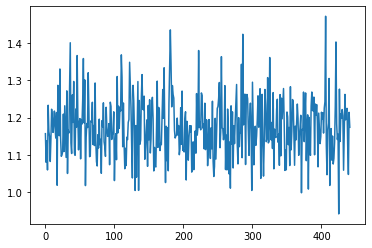

In [53]:
plt.plot(range(len(lossi)), [i.item() for i in lossi])

In [28]:
eval_model = SimpleModel().to(device)
eval_model.load_state_dict(torch.load('/kaggle/input/mlp-1-without-okz/mlp_1_without_okz'))

<All keys matched successfully>

In [57]:
test_raw = pd.read_csv('/kaggle/input/bytedatahack-22/test.csv')
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1090 non-null   int64 
 1   name         1090 non-null   object
 2   description  1090 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.7+ KB


In [58]:
test_data = pipeline.transform(test_raw)

In [59]:
preds = None

model.eval()
with torch.no_grad():
    for x_batch in tqdm(iter_batches(test_data, shuffle=False)):
        logits = model(x_batch)
        if type(preds) == type(None):
            preds = F.softmax(logits)
        else:
            preds = torch.cat([preds, F.softmax(logits)])        

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [60]:
result = pd.DataFrame(dict(index=test_data['index'], target=le.inverse_transform(preds.argmax(-1).detach().cpu().numpy())))
result.to_csv('submission.csv', index=None)

In [61]:
tokenizer = AutoTokenizer.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")
model = AutoModel.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")

Downloading:   0%|          | 0.00/792 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at RussianNLP/ruRoBERTa-large-rucola were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at RussianNLP/ruRoBERTa-large-rucola and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

In [82]:
max_len = max(max(X_train['full_description'].apply(lambda x: len(x))), max(X_test['full_description'].apply(lambda x: len(x))))

In [99]:
def iter_batches(x, y=None, shuffle=True, batch_size=256, device=device):
    indices = np.arange(len(x))
    
    if shuffle:
        indices = np.random.permutation(indices)
    
    for start in range(0, len(indices), batch_size):
        res = tokenizer(list(x.iloc[indices[start:start+batch_size]]['full_description'].values), padding=True, add_special_tokens=True, truncation=True, max_length=513, return_tensors='pt')
#         emb = embed_bert_cls(list(x.iloc[indices[start:start+batch_size]]['full_description'].values), model, tokenizer)
        if type(y) == type(None):
            yield res 
        else:
            yield res, torch.tensor(y[indices[start:start+batch_size]], device=device)

In [ ]:
model(**next(iter_batches(X_train, y_train))[0])

In [88]:
tokenizer(['sdf', 'sdf'])

{'input_ids': [[1, 87, 72, 74, 2], [1, 87, 72, 74, 2]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}

In [1]:
model

NameError: name 'model' is not defined

In [ ]:
CatBoostC